IMPORT LIBRARY

In [1]:
!pip install tf2onnx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import tf2onnx

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0

In [2]:
df = pd.read_csv('diabetes.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [4]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


In [5]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [6]:
df.shape

(100000, 9)

DATA PREPROCESSING

In [7]:
# Encode fitur categorical
categorical_cols = ['gender', 'smoking_history']

In [8]:
# Encode setiap kolom categorical ke angka
encoders = {}
for column in categorical_cols:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])
    encoders[column] = label_encoder

In [9]:
# Encode label/target
label_encoder = LabelEncoder()
print(df.columns) # Examine this output to find the correct column name
# Replace 'Obesitas' with the actual column name from the print output
df['diabetes'] = label_encoder.fit_transform(df['diabetes'])

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')


In [10]:
# Normalisasi fitur numeric
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [11]:
# Memisahkan fitur dan label
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [12]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,1.692704,0,1,4,-0.321056,1.001706,0.047704,0
1,0,0.538006,0,0,0,-0.000116,1.001706,-1.426210,0
2,1,-0.616691,0,0,4,-0.000116,0.161108,0.489878,0
3,0,-0.261399,0,0,1,-0.583232,-0.492690,0.416183,0
4,1,1.515058,1,1,1,-1.081970,-0.679490,0.416183,0


In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Cek jumlah kelas output
num_classes = len(np.unique(y))
print("Jumlah kelas output:", num_classes)

Jumlah kelas output: 2


NEURAL NETWORK MODEL

In [15]:
# Buat model neural network
model = Sequential([
    Dense(64, input_dim=X.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Gunakan sigmoid untuk binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
# Latih model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9342 - loss: 0.1941 - val_accuracy: 0.9622 - val_loss: 0.1061
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9639 - loss: 0.1074 - val_accuracy: 0.9674 - val_loss: 0.0934
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9672 - loss: 0.0972 - val_accuracy: 0.9697 - val_loss: 0.0894
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9684 - loss: 0.0929 - val_accuracy: 0.9707 - val_loss: 0.0868
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9678 - loss: 0.0932 - val_accuracy: 0.9706 - val_loss: 0.0867
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9715 - loss: 0.0849 - val_accuracy: 0.9711 - val_loss: 0.0855
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9716 - loss: 0.0848 - val_accuracy: 0.9708 - val_loss: 0.0854
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9704 - loss: 0.08

MODEL EVALUATION

In [18]:
# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Akurasi: {accuracy:.4f}")

Loss: 0.0807
Akurasi: 0.9721


In [19]:
# Prediksi dan evaluasi tambahan
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       1.00      0.67      0.80      1708

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000

Confusion Matrix:
[[18291     1]
 [  557  1151]]


<Figure size 600x500 with 0 Axes>

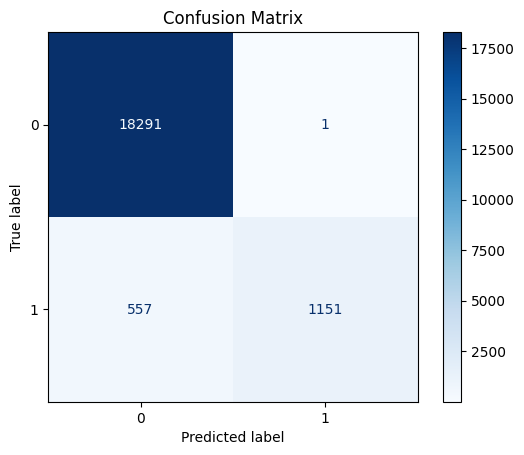

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Tampilkan confusion matrix dalam bentuk gambar
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

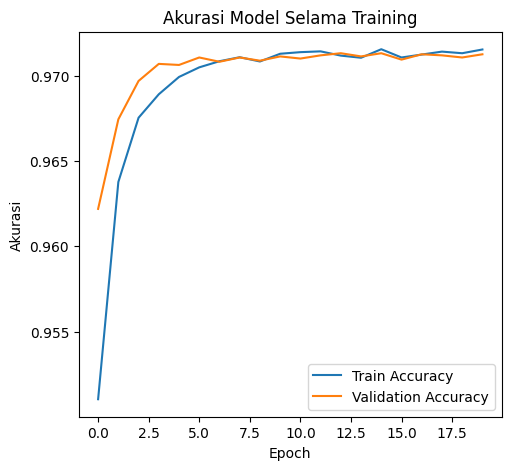

In [21]:
# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model Selama Training')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

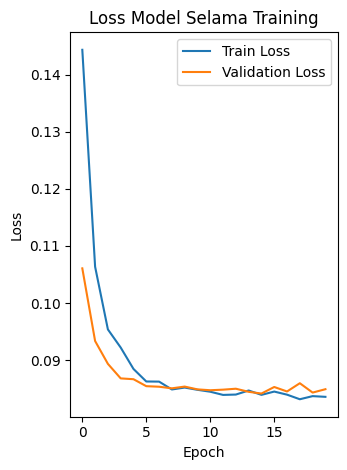

In [22]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model Selama Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

SAVE MODEL AND SCALER

In [31]:
# Save the model
model.save('diabetes_prediction_model.h5')
print("Model saved as 'diabetes_prediction_model.h5'")

Model saved as 'diabetes_prediction_model.h5'


In [32]:
# Save the scaler
import joblib
joblib.dump(scaler, 'diabetes_scaler.pkl')
print("Scaler saved as 'diabetes_scaler.pkl'")

Scaler saved as 'diabetes_scaler.pkl'


inference

In [33]:
new_data_raw = pd.DataFrame([{
    'gender': 'Female',
    'age': 45,
    'hypertension': 0,
    'heart_disease': 0,
    'smoking_history': 'never',
    'bmi': 28.5,
    'HbA1c_level': 6.2,
    'blood_glucose_level': 145
}])

In [34]:
# Encode fitur kategori dengan encoder yang sama
for column in ['gender', 'smoking_history']:
    new_data_raw[column] = encoders[column].transform(new_data_raw[column])

In [35]:
# Normalisasi fitur numerik
new_data_scaled = new_data_raw.copy()
new_data_scaled[numerical_cols] = scaler.transform(new_data_scaled[numerical_cols])

In [36]:
# Prediksi
prediction_prob = model.predict(new_data_scaled)[0][0]
prediction_label = (prediction_prob > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [38]:
# Decode label prediksi
predicted_class = label_encoder.inverse_transform([prediction_label])[0]

print(f"Probabilitas terkena diabetes: {prediction_prob:.4f}")
print(f"Hasil prediksi: {predicted_class}")

Probabilitas terkena diabetes: 0.0402
Hasil prediksi: 0


hasil akurat: tidak diabetes

konversi model ke onnx

In [40]:
# Konversi model ke format ONNX
# Wrap the Sequential model in a functional Model
inputs = tf.keras.Input(shape=(X.shape[1],), name="input")
outputs = model(inputs)
functional_model = tf.keras.Model(inputs=inputs, outputs=outputs)

spec = (tf.TensorSpec((None, X.shape[1]), tf.float32, name="input"),)

onnx_model, _ = tf2onnx.convert.from_keras(functional_model, # Use the functional_model
                                           input_signature=spec,
                                           opset=13,
                                           output_path="diabetes_model.onnx")

print("Model berhasil dikonversi ke ONNX dan disimpan sebagai diabetes_model.onnx")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7ade3dd4d3a0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


Model berhasil dikonversi ke ONNX dan disimpan sebagai diabetes_model.onnx
